In [1]:
!which python

/Users/mohankumar/anaconda3/envs/churn-model/bin/python


In [2]:
%load_ext autoreload
%autoreload 2

In [63]:
#standard imports
import os
import sys
import pickle
sys.path.append('..')

#Third-party library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

#Local imports
from src.localpaths import *
from src.data.make_dataset import load_training_data, load_test_data
from src.models.train_model import store_model_and_results, print_model_results

In [4]:
#pd.options.display.max_columns=100
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

## 01. Load Data

In [5]:
df = pd.read_csv(RAW_DATA_PATH)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Descriptive Statistics

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**TotalCharges needs more research:** it looks like TotalCharges is an `object` data type even though it should be `float` 

In [8]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [10]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


array([[<AxesSubplot:title={'center':'SeniorCitizen'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'MonthlyCharges'}>, <AxesSubplot:>]],
      dtype=object)

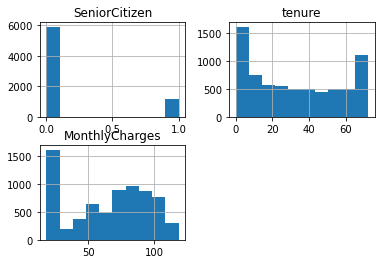

In [11]:
df.hist()

## Target Balance

In [12]:
(df['Churn'].value_counts() / df.shape[0]).round(2)

No     0.73
Yes    0.27
Name: Churn, dtype: float64

## Load training data

In [13]:
X_train, y_train = load_training_data(clean=True)

## Basic EDA - distribution of features

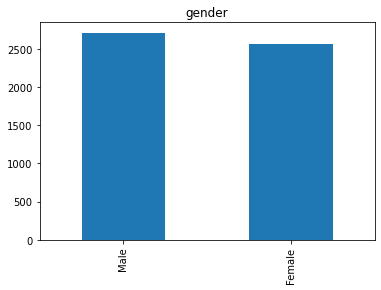

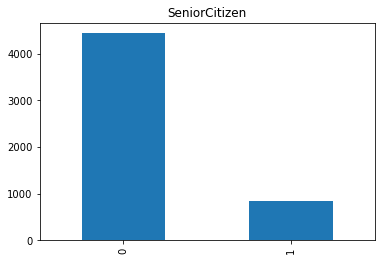

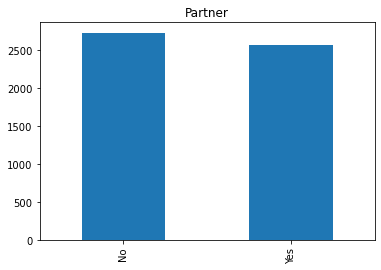

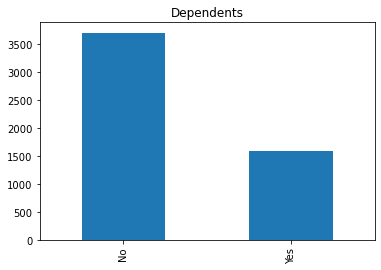

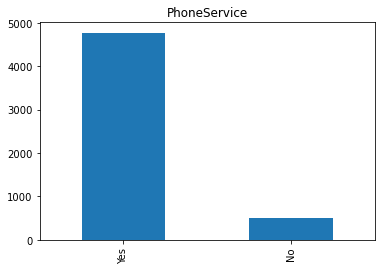

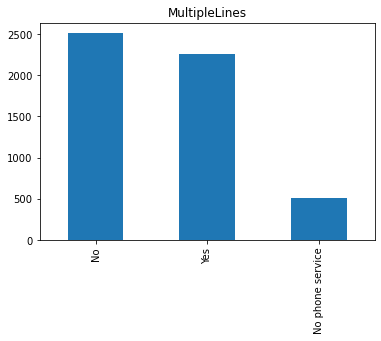

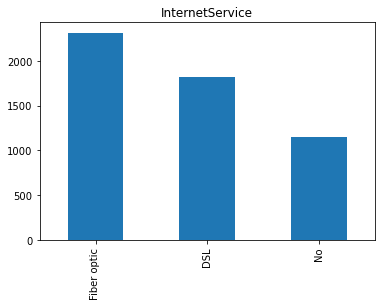

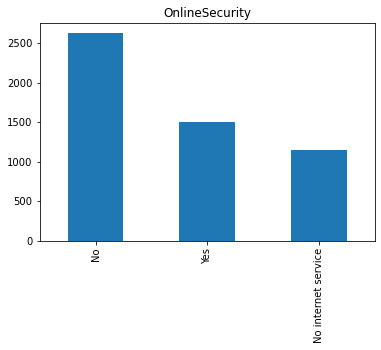

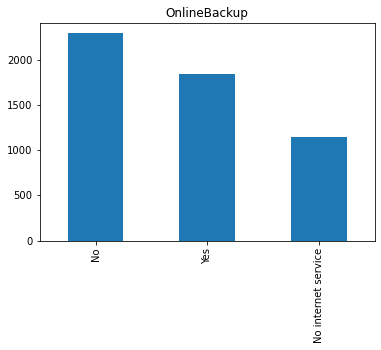

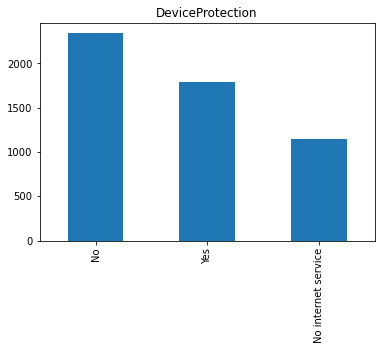

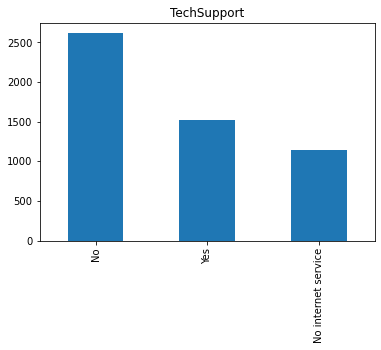

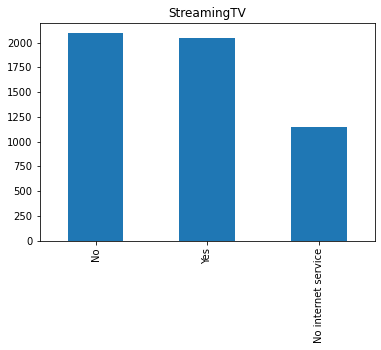

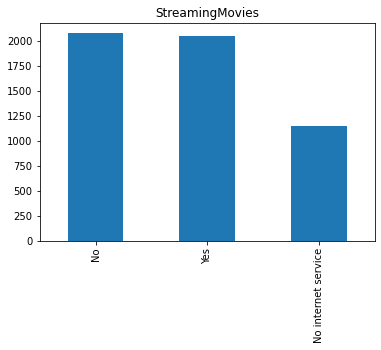

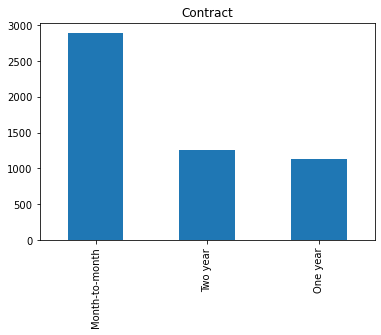

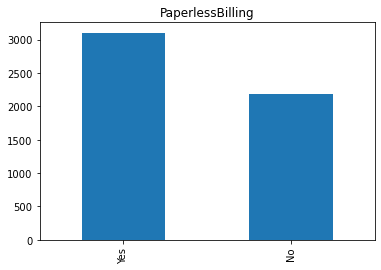

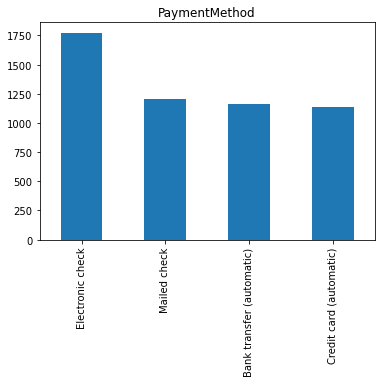

In [14]:
for col in X_train.columns:
    if len(X_train[col].unique()) <= 4:
        X_train[col].value_counts().plot(kind='bar')
        plt.title(col)
        plt.show()

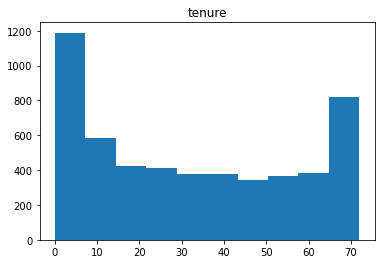

In [15]:
X_train['tenure'].hist(grid=False)
plt.title('tenure')
plt.show()

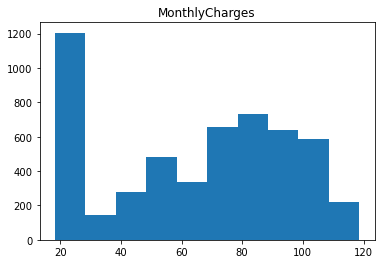

In [16]:
X_train['MonthlyCharges'].hist(grid=False)
plt.title('MonthlyCharges')
plt.show()

## Inspect TotalCharges

In [17]:
# bad_values = set()
# for val in X_train['TotalCharges'].unique():
#     try:
#         float(val)
#     except:
#         bad_values.add(val)

# (X_train['TotalCharges'] == ' ').sum()

# total_charges = X_train[ X_train['TotalCharges']!=' ' ]['TotalCharges'].map(float)

# total_charges.describe()

# # since the distribution is skewed, i choose 20 be a good value to impute TotalCharges missing value
# bad_values_idxs = X_train[ X_train['TotalCharges'] == ' '].index
# X_train.loc[ bad_values_idxs, 'TotalCharges'] = 20
# X_train['TotalCharges'] = X_train['TotalCharges'].astype(float)

# X_train['TotalCharges'].describe()

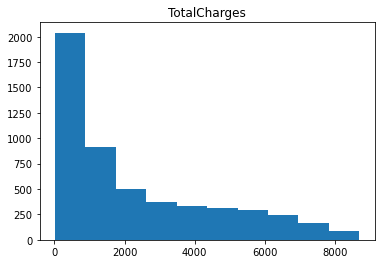

In [18]:
X_train['TotalCharges'].hist(grid=False)
plt.title('TotalCharges')
plt.show()

## 02.Load Featurized Data 

In [5]:
X_train, y_train = load_training_data(final=True)

In [23]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,1,0,1,25.30,25.30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,7,1,1,75.15,525.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0,0,1,4,1,1,20.05,85.50,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,29,1,1,76.00,2215.25,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,0,0,0,3,1,1,75.10,270.70,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
X_train.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.000000,0.005691,0.010143,-0.011058,-0.001318,0.009706,0.014090,0.018822,0.007934,-0.009706,0.003307,0.014528,-0.003996,-0.003996,0.021021,-0.003996,0.025536,-0.003996,0.010371,-0.003996,0.011906,-0.003996,0.013873,-0.003996,0.012052,-0.008001,0.003300,0.000447,-0.006270,-0.004089
SeniorCitizen,0.005691,1.000000,0.016648,-0.211271,0.006169,0.000581,0.156417,0.219945,0.093900,-0.000581,0.123974,0.255584,-0.189718,-0.189718,-0.036739,-0.189718,0.070836,-0.189718,0.067831,-0.189718,-0.057097,-0.189718,0.102617,-0.189718,0.119373,-0.046580,-0.125754,-0.024547,0.167972,-0.147658
Partner,0.010143,0.016648,1.000000,0.447629,0.382443,0.031578,-0.020634,0.105603,0.324533,-0.031578,0.154350,0.009474,0.000755,0.000755,0.151724,0.000755,0.153876,0.000755,0.156254,0.000755,0.125586,0.000755,0.124236,0.000755,0.110650,0.086468,0.254102,0.105695,-0.082986,-0.108460
Dependents,-0.011058,-0.211271,0.447629,1.000000,0.162921,-0.005830,-0.109935,-0.114920,0.063421,0.005830,-0.021619,-0.169426,0.139496,0.139496,0.085854,0.139496,0.027996,0.139496,0.010485,0.139496,0.066857,0.139496,-0.017083,0.139496,-0.037314,0.062427,0.206994,0.082329,-0.152754,0.053380
tenure,-0.001318,0.006169,0.382443,0.162921,1.000000,0.005917,0.004055,0.253618,0.827555,-0.005917,0.342159,0.025088,-0.043782,-0.043782,0.329459,-0.043782,0.361964,-0.043782,0.361612,-0.043782,0.330507,-0.043782,0.280702,-0.043782,0.292136,0.203930,0.556371,0.238479,-0.200369,-0.233260
PhoneService,0.009706,0.000581,0.031578,-0.005830,0.005917,1.000000,0.014489,0.247419,0.113558,-1.000000,0.282513,0.288234,0.172087,0.172087,-0.086044,0.172087,-0.058281,0.172087,-0.074532,0.172087,-0.084202,0.172087,-0.022690,0.172087,-0.028911,-0.010171,0.010091,-0.022687,0.008085,0.006735
PaperlessBilling,0.014090,0.156417,-0.020634,-0.109935,0.004055,0.014489,1.000000,0.359566,0.163911,-0.014489,0.169690,0.333920,-0.327897,-0.327897,0.010410,-0.327897,0.123735,-0.327897,0.112994,-0.327897,0.041767,-0.327897,0.230622,-0.327897,0.206972,-0.051368,-0.156178,-0.021134,0.214575,-0.207767
MonthlyCharges,0.018822,0.219945,0.105603,-0.114920,0.253618,0.247419,0.359566,1.000000,0.654344,-0.247419,0.492456,0.784458,-0.763444,-0.763444,0.301343,-0.763444,0.446048,-0.763444,0.483399,-0.763444,0.346062,-0.763444,0.630747,-0.763444,0.630638,0.003284,-0.067417,0.021418,0.271453,-0.375811
TotalCharges,0.007934,0.093900,0.324533,0.063421,0.827555,0.113558,0.163911,0.654344,1.000000,-0.113558,0.477110,0.363926,-0.377919,-0.377919,0.413964,-0.377919,0.511171,-0.377919,0.522223,-0.377919,0.439774,-0.377919,0.513516,-0.377919,0.525159,0.168169,0.357305,0.179514,-0.052095,-0.294976
MultipleLines_No phone service,-0.009706,-0.000581,-0.031578,0.005830,-0.005917,-1.000000,-0.014489,-0.247419,-0.113558,1.000000,-0.282513,-0.288234,-0.172087,-0.172087,0.086044,-0.172087,0.058281,-0.172087,0.074532,-0.172087,0.084202,-0.172087,0.022690,-0.172087,0.028911,0.010171,-0.010091,0.022687,-0.008085,-0.006735


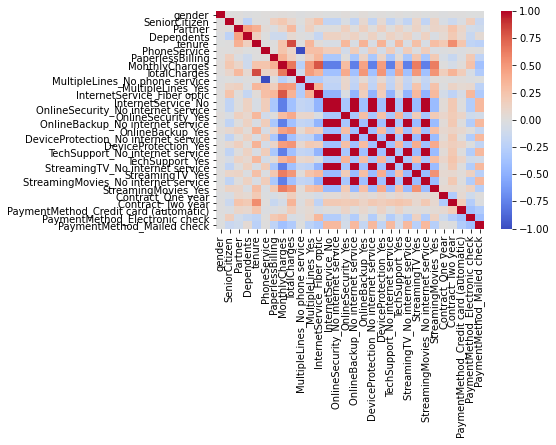

In [28]:
sns.heatmap( X_train.corr(), cmap='coolwarm', center=0, xticklabels=True ,yticklabels=True )
plt.show()

In [29]:
correlations = X_train.corr()

In [32]:
correlations = correlations.unstack().reset_index()

In [34]:
# This step make sure that the 'gender and seniorcitizen' taken to account but not 'seniorcitizen and gender'
correlations = correlations[ correlations['level_0'] < correlations['level_1'] ]

In [35]:
correlations

,level_0,level_1,0
4,gender,tenure,-0.001318
30,SeniorCitizen,gender,0.005691
34,SeniorCitizen,tenure,0.006169
38,SeniorCitizen,TotalCharges,0.093900
49,SeniorCitizen,TechSupport_No internet service,-0.189718
...,...,...,...
890,PaymentMethod_Mailed check,TechSupport_Yes,-0.087459
891,PaymentMethod_Mailed check,StreamingTV_No internet service,0.324005
892,PaymentMethod_Mailed check,StreamingTV_Yes,-0.246234
893,PaymentMethod_Mailed check,StreamingMovies_No internet service,0.324005


In [38]:
correlations.sort_values( by=0, ascending=False ).head(100)

,level_0,level_1,0
463,OnlineBackup_No internet service,OnlineSecurity_No internet service,1.000000
709,StreamingMovies_No internet service,TechSupport_No internet service,1.000000
413,OnlineSecurity_No internet service,StreamingMovies_No internet service,1.000000
411,OnlineSecurity_No internet service,StreamingTV_No internet service,1.000000
409,OnlineSecurity_No internet service,TechSupport_No internet service,1.000000
533,DeviceProtection_No internet service,StreamingMovies_No internet service,1.000000
531,DeviceProtection_No internet service,StreamingTV_No internet service,1.000000
529,DeviceProtection_No internet service,TechSupport_No internet service,1.000000
525,DeviceProtection_No internet service,OnlineBackup_No internet service,1.000000
523,DeviceProtection_No internet service,OnlineSecurity_No internet service,1.000000


In [39]:
sorted( correlations.values, key=lambda x: abs(x[2]), reverse=True )

[array(['MultipleLines_No phone service', 'PhoneService', -1.0],
       dtype=object),
 array(['InternetService_No', 'OnlineSecurity_No internet service', 1.0],
       dtype=object),
 array(['InternetService_No', 'OnlineBackup_No internet service', 1.0],
       dtype=object),
 array(['InternetService_No', 'TechSupport_No internet service', 1.0],
       dtype=object),
 array(['InternetService_No', 'StreamingTV_No internet service', 1.0],
       dtype=object),
 array(['InternetService_No', 'StreamingMovies_No internet service', 1.0],
       dtype=object),
 array(['OnlineSecurity_No internet service',
        'TechSupport_No internet service', 1.0], dtype=object),
 array(['OnlineSecurity_No internet service',
        'StreamingTV_No internet service', 1.0], dtype=object),
 array(['OnlineSecurity_No internet service',
        'StreamingMovies_No internet service', 1.0], dtype=object),
 array(['OnlineBackup_No internet service',
        'OnlineSecurity_No internet service', 1.0], dtype=obje

## Look at feature correlations with churn

In [41]:
X_train.assign(**y_train).corr()[['Churn']].sort_values( by='Churn', ascending=False )

,Churn
Churn,1.000000
InternetService_Fiber optic,0.300112
PaymentMethod_Electronic check,0.294180
PaperlessBilling,0.188793
MonthlyCharges,0.186615
SeniorCitizen,0.146549
StreamingMovies_Yes,0.060152
StreamingTV_Yes,0.054414
MultipleLines_Yes,0.033019
gender,0.011997


## 03. Basic Modeling

## Set up the modeling pipeline

1. Train the model.
2. Evaluate how good the model is. (Look at the results)
3. Pickle the model to the models directory
4. Save the model reslults to a CSV to track how each of our models performs.

## Split off training and validation sets

In [8]:
X, X_validation, y , y_validation = train_test_split( X_train, y_train, test_size=0.25, random_state=42 )

In [9]:
X.shape, y.shape, X_validation.shape, y_validation.shape

((3961, 30), (3961, 1), (1321, 30), (1321, 1))

## Set up our model

In [11]:
model = LogisticRegression()

In [12]:
model.fit(X, y)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [18]:
# Model accuracy - manual
np.mean( model.predict(X_validation) == y_validation.values[:, 0].astype(int) )

0.7956093868281605

In [19]:
# Model accuracy - scikit-learn
model.score( X_validation, y_validation )

0.7956093868281605

## Pickle our model

In [22]:
model_filename = str( hash( np.random.rand() )) + '.pkl'
model_filename

'2182843720249625856.pkl'

In [26]:
with open( os.path.join(MODELS_DIRECTORY, model_filename) , 'wb') as f:
    pickle.dump(model, f)

## Save model results to CSV file

In [30]:
data_to_save = {
    'model_filename': [model_filename],
    'model_string': [str(model)],
    'accuracy': [model.score(X_validation, y_validation)]
}

In [31]:
data_to_save

{'model_filename': ['2182843720249625856.pkl'],
 'model_string': ['LogisticRegression()'],
 'accuracy': [0.7956093868281605]}

In [39]:
df_results = pd.DataFrame( data_to_save )
df_results

,model_filename,model_string,accuracy
0,2182843720249625856.pkl,LogisticRegression(),0.795609


In [40]:
model_results_filename = 'model_results.csv'
df_results.to_csv( os.path.join( MODELS_DIRECTORY, model_results_filename ) ,index=False )

In [62]:
df_results_test = pd.read_csv( os.path.join( MODELS_DIRECTORY, model_results_filename ))
df_results_test

,model_filename,model_string,accuracy,precision,recall,f1,roc_auc
0,1224355746000281600.pkl,LogisticRegression(),0.795609,NaN,NaN,NaN,NaN
1,1238009896048385024.pkl,LogisticRegression(),0.795609,NaN,NaN,NaN,NaN
2,1627872541946510848.pkl,LogisticRegression(max_iter=1000),0.801966,0.653366,0.529496,0.584391,0.840393


## Test our model-storing function

In [51]:
store_model_and_results( model, X_train, y_train )

saving pickled model to 1238009896048385024.pkl
writing model results to existing results CSV file


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Cross Validation

In [60]:
model = LogisticRegression(max_iter=1000)
print( np.mean( cross_val_score(model, X_train, y_train['Churn'], scoring='accuracy' ) ))

0.8019663283736131


In [58]:
print("scikit-learn model evaluation metrics:")
print()
for k in sklearn.metrics.SCORERS.keys():
    print(k)

scikit-learn model evaluation metrics:

explained_variance
r2
max_error
neg_median_absolute_error
neg_mean_absolute_error
neg_mean_squared_error
neg_mean_squared_log_error
neg_root_mean_squared_error
neg_mean_poisson_deviance
neg_mean_gamma_deviance
accuracy
roc_auc
roc_auc_ovr
roc_auc_ovo
roc_auc_ovr_weighted
roc_auc_ovo_weighted
balanced_accuracy
average_precision
neg_log_loss
neg_brier_score
adjusted_rand_score
homogeneity_score
completeness_score
v_measure_score
mutual_info_score
adjusted_mutual_info_score
normalized_mutual_info_score
fowlkes_mallows_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
recall
recall_macro
recall_micro
recall_samples
recall_weighted
f1
f1_macro
f1_micro
f1_samples
f1_weighted
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted


## Test new model-storing function with additional metrics

In [61]:
model = LogisticRegression(max_iter=1000)
store_model_and_results( model, X_train, y_train )

fitting model before pickling
saving pickled model to 1627872541946510848.pkl
writing model results to existing results CSV file


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [64]:
print_model_results(model, X_train, y_train)

accuracy : 0.80
precision : 0.65
recall : 0.53
f1 : 0.58
roc_auc : 0.84
